In [1]:
import requests
from datetime import datetime, timedelta
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import johnsonsu
from scipy.optimize import minimize
import csv
import pandas as pd

In [2]:
key='&apikey=ZKMMTO1ATDBLXH2K' # API Key
ticker='&symbol=SPY' # Ticker
endpoint='function=TIME_SERIES_DAILY_ADJUSTED' # Called 'function', the dataset we want
size='&outputsize=full'
web='https://www.alphavantage.co/query?'
url =web+endpoint+ticker+size+key

r = requests.get(url)
print(r.status_code) # 200 good, 400 bad
data = r.json()

print(data.keys()) #printing the keys
meta = data['Meta Data']
time_series_data = data['Time Series (Daily)']

ts_df = pd.DataFrame.from_dict(time_series_data, orient='index').reset_index().rename(columns={'index': 'Date'})
clean_cols_dict = {'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', # Dictionary to convert the names of the columns
            '5. adjusted close': 'Adj Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend', '8. split coefficient': 'Split Coef'}
ts_df = ts_df.rename(columns=clean_cols_dict)

clean=[] # This is how you do it with standard Python
for date in time_series_data.keys():
    # print (r1[date])
    clean.append([date, meta['2. Symbol'], time_series_data[date]['4. close']]) #stacking prices


ts_np = ts_df.to_numpy() # How to convert a df to a 2d numpy matrix
ts_df = ts_df.sort_values(by='Date', ascending=True)
ts_df['Adj Close'] = ts_df['Adj Close'].astype(float)
ts_df['Date'] = pd.to_datetime(ts_df['Date'])
ts_df

200
dict_keys(['Meta Data', 'Time Series (Daily)'])


,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,Split Coef
6596,1999-11-01,136.5,137.0,135.5625,135.5625,85.122145,4006500,0.0000,1.0
6595,1999-11-02,135.968704,137.25,134.593704,134.593704,84.513820,6516900,0.0000,1.0
6594,1999-11-03,136.0,136.375,135.125,135.5,85.082900,7222300,0.0000,1.0
6593,1999-11-04,136.75,137.359299,135.765594,136.531204,85.730412,7907500,0.0000,1.0
6592,1999-11-05,138.625,139.109299,136.781204,137.875,86.574205,7431500,0.0000,1.0
...,...,...,...,...,...,...,...,...,...
4,2026-01-16,693.66,694.25,690.1,691.66,691.660000,79289200,0.0000,1.0
3,2026-01-20,681.49,684.77,676.57,677.58,677.580000,107178877,0.0000,1.0
2,2026-01-21,679.65,688.735,678.13,685.4,685.400000,127844467,0.0000,1.0
1,2026-01-22,689.85,691.13,686.92,688.98,688.980000,77112243,0.0000,1.0


In [49]:
# 2. Set the date column as the index (required for resampling)
monthly_df = ts_df.set_index('Date')

# 3. Create a Series of just the Month-End prices
# 'ME' stands for Month End. (Use 'M' if you are on an older version of Pandas)
# Instead of resample, use groupby with a Grouper
# tail(1) grabs the last actual row of the month, preserving its original Date index
monthly_prices = monthly_df.groupby(pd.Grouper(freq='ME')).tail(1)['Adj Close']

# 4. Calculate the Log Return
# Formula: ln(Current Month Price) - ln(Previous Month Price)
monthly_log_returns = np.log(monthly_prices) - np.log(monthly_prices.shift(1))

# Optional: Put it into a readable DataFrame
monthly_summary = pd.DataFrame({
    'Month End Price': monthly_prices,
    'Monthly Log Return': monthly_log_returns
})

monthly_summary = monthly_summary[['Monthly Log Return']].reset_index()
monthly_summary

,Date,Monthly Log Return
0,1999-11-30,NaN
1,1999-12-31,0.055520
2,2000-01-31,-0.051069
3,2000-02-29,-0.015343
4,2000-03-31,0.092483
...,...,...
310,2025-09-30,0.034987
311,2025-10-31,0.023558
312,2025-11-28,0.001948
313,2025-12-31,0.000771


In [50]:
ts_df = pd.merge(ts_df, monthly_summary, on='Date', how='left')


In [51]:
threshold = ts_df['Monthly Log Return'].quantile(0.025)
buy = []

for index, row in ts_df.iterrows():
    if pd.isna(row['Monthly Log Return']):
        buy.append(0)
        continue
    elif row['Monthly Log Return'] < threshold:
        buy.append(1)
    else:
        buy.append(0)

ts_df['Buy'] = buy
ts_df['Sell'] = ts_df['Buy'].shift(1)

buy_price = 0

returns = []
for index, row in ts_df.iterrows():
    if row['Buy'] == 1:
        buy_price = row['Adj Close']
        returns.append(0)
    elif row['Sell'] == 1:
        sell_price = row['Adj Close']
        day_return = np.log(sell_price) - np.log(buy_price)
        returns.append(day_return)
    else:
        returns.append(0)

ts_df['Strategy Return'] = returns


In [ ]:
strategy_df = ts_df[(ts_df['Buy'] == 1) | (ts_df['Sell'] == 1)]
returns_df = ts_df[ts_df['Sell'] == 1]



,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,Split Coef,Monthly Log Return,Buy,Sell,Strategy Return
335,2001-03-01,124.050003,124.599998,121.75,124.599998,79.264735,14672000,0.0000,1.0,NaN,0,1.0,0.005230
731,2002-10-01,82.43,85.769997,81.470001,85.720001,55.835258,67198100,0.0000,1.0,NaN,0,1.0,0.046931
2242,2008-10-01,115.269997,116.690002,113.949997,116.059998,84.341352,332783000,0.0000,1.0,NaN,0,1.0,0.000603
2265,2008-11-03,96.779999,97.690002,95.949997,97.110001,70.570299,205419400,0.0000,1.0,NaN,0,1.0,0.002887
2345,2009-03-02,72.519997,73.919998,70.370003,70.599998,51.723837,426452600,0.0000,1.0,NaN,0,1.0,-0.046089
4822,2019-01-02,245.98,251.21,245.95,250.18,224.868305,126925199,0.0000,1.0,NaN,0,1.0,0.001040
5136,2020-04-01,247.98,257.66,243.9,246.15,226.816709,188373330,0.0000,1.0,NaN,0,1.0,-0.046049
5767,2022-10-03,361.08,368.55,359.21,366.61,350.756481,89756479,0.0000,1.0,NaN,0,1.0,0.026059


In [59]:
x = returns_df['Strategy Return'].tolist()
t_stat, p_val = stats.ttest_1samp(x, 0) 
t_stat, p_val

(np.float64(-0.10382260127307678), np.float64(0.9202221275277256))

In [ ]:
# log(a) - log(b) = log(a/b)
ts_df['Monthly Log Return'] = np.log(ts_df['Adj Close'] / ts_df['Adj Close'].shift(1))
p2_5 = ts_df['Monthly Log Return'].quantile(0.025)


-0.09189884660357991


In [23]:
# Part 2 Functions
def moment_objective(params, sample_moments):
    gamma, delta, xi, lam = params
    
    # Mathematical Safety: 
    # If parameters drift into 'exploding' territory, punish them immediately
    if delta < 0.1 or lam <= 0:
        return np.inf

    try:
        # Calculate theoretical moments
        # Note: Scipy returns 'Excess Kurtosis' (Fisher) by default, matching your sample calc
        mvsk = stats.johnsonsu.stats(gamma, delta, loc=xi, scale=lam, moments='mvsk')
        theo_mean, theo_var, theo_skew, theo_kurt = mvsk
        
        samp_mean, samp_var, samp_skew, samp_kurt = sample_moments

        # Use Weighted Squared Error (Percentage Error)
        # This ensures the optimizer treats the Mean (0.001) as just as important as Kurtosis (5.0)
        err_mean = ((theo_mean - samp_mean) / 1.0)**2 # Mean is close to 0, so abs diff is better here
        err_var  = ((theo_var - samp_var) / samp_var)**2
        err_skew = ((theo_skew - samp_skew) / (1 + abs(samp_skew)))**2
        err_kurt = ((theo_kurt - samp_kurt) / (1 + abs(samp_kurt)))**2

        return err_mean + err_var + err_skew + err_kurt

    except Exception:
        return np.inf

def fit_johnson_su_moments(sample_mean, sample_variance, sample_skew, sample_kurt):
    sample_moments = [sample_mean, sample_variance, sample_skew, sample_kurt]
    
    # Initial Guess
    # Delta=1.0 is safer than 1.0 if using small bounds, but 1.0 is a standard start
    initial_guess = [0.0, 1.0, sample_mean, np.sqrt(sample_variance)]
    
    # CRITICAL FIX: Adjusted Bounds
    # Delta: Raised min to 0.5 to prevent exp(1/d^2) explosion
    # Lam: Lowered min to 1e-6 because daily returns are small (approx 0.01)
    bounds = [(-10, 10), (0.5, 20), (None, None), (1e-6, 10)]
    
    result = minimize(moment_objective, initial_guess, args=(sample_moments,), bounds=bounds, method='L-BFGS-B')
    
    if result.success:
        return result.x
    else:
        print(f"Warning: Optimization failed - {result.message}")
        # Return best guess anyway to prevent crash, or raise error if preferred
        return result.x 

def get_johnson_su_moments(gamma, delta, xi, lam):
    mean, variance, skewness, kurtosis = stats.johnsonsu.stats(gamma, delta, loc=xi, scale=lam, moments='mvsk')
    return {'first': mean, 'second': variance, 'third': skewness, 'fourth': kurtosis}

def plot_johnson_vs_actual(returns, gamma, delta, xi, lam, bins=50):
    # Create a range of x values for the smooth line
    # We go slightly past the min/max of actual returns to make the curve look complete
    x = np.linspace(min(returns) * 1.2, max(returns) * 1.2, 1000)
    
    # Calculate the theoretical PDF using the fitted parameters
    pdf = stats.johnsonsu.pdf(x, gamma, delta, loc=xi, scale=lam)

    plt.figure(figsize=(10, 6))
    
    # Plot the Histogram of actual data
    plt.hist(returns, bins=int(bins), density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Empirical Returns')
    
    # Plot the Fitted Johnson SU line
    plt.plot(x, pdf, 'r-', lw=2, label=f'Fitted Johnson SU\n($\gamma$={gamma:.2f}, $\delta$={delta:.2f})')
    
    # Labels and titles
    plt.title('Fitted Johnson SU Distribution vs. Daily Returns')
    plt.xlabel('Log Return')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def get_jsu_threshold(percentile, gamma, delta, xi, lam): # 
    """
    Calculates the return value at the bottom x% of the fitted Johnson SU distribution.
    
    Args:
        percentile (float): The decimal percentage (e.g., 0.025 for 2.5%).
        gamma, delta, xi, lam: The fitted Johnson SU parameters.
        
    Returns:
        float: The daily return threshold (scalar).
    """
    # ppf = Percentile Point Function (Inverse CDF)
    threshold = stats.johnsonsu.ppf(percentile, gamma, delta, loc=xi, scale=lam)
    return threshold

<>:69: SyntaxWarning: invalid escape sequence '\g'
<>:69: SyntaxWarning: invalid escape sequence '\d'
<>:69: SyntaxWarning: invalid escape sequence '\g'
<>:69: SyntaxWarning: invalid escape sequence '\d'
C:\Users\willf\AppData\Local\Temp\ipykernel_46180\861358549.py:69: SyntaxWarning: invalid escape sequence '\g'
  plt.plot(x, pdf, 'r-', lw=2, label=f'Fitted Johnson SU\n($\gamma$={gamma:.2f}, $\delta$={delta:.2f})')
C:\Users\willf\AppData\Local\Temp\ipykernel_46180\861358549.py:69: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(x, pdf, 'r-', lw=2, label=f'Fitted Johnson SU\n($\gamma$={gamma:.2f}, $\delta$={delta:.2f})')


In [21]:
# Settingup Data for Part 2

dr_df = ts_df[['Date', 'Adj Close']].copy() # "Daily Return df" Gets us just the date and our Adj Close which we use for return calculations


dr_df['Daily Return'] = np.log(dr_df['Adj Close'] / dr_df['Adj Close'].shift(1)) # This calculates the log return every day
returns = dr_df['Daily Return'].dropna().tolist() # Take our returns in to a list, removing NaN values

returns_mean = np.mean(returns) # Mean/Average
returns_variance = np.var(returns) #Variance/Sigma^2
returns_skewness = stats.skew(returns) # Skew
returns_kurtosis = stats.kurtosis(returns, fisher=True) # Kurtosis

print(f"Sample Moments: Mean={returns_mean:.5f}, Var={returns_variance:.5f}, Skew={returns_skewness:.2f}, Kurt={returns_kurtosis:.2f}") # The moments calculated above


Sample Moments: Mean=0.00032, Var=0.00015, Skew=-0.21, Kurt=11.57


Fitted Params: Gamma=0.05, Delta=1.18, Xi=0.00043, Lam=0.00963
Theoretical Moments of Fit: {'first': np.float64(-0.00010371951212536051), 'second': np.float64(0.0001484773423059021), 'third': np.float64(-0.21062888236588362), 'fourth': np.float64(11.566270271031932)}


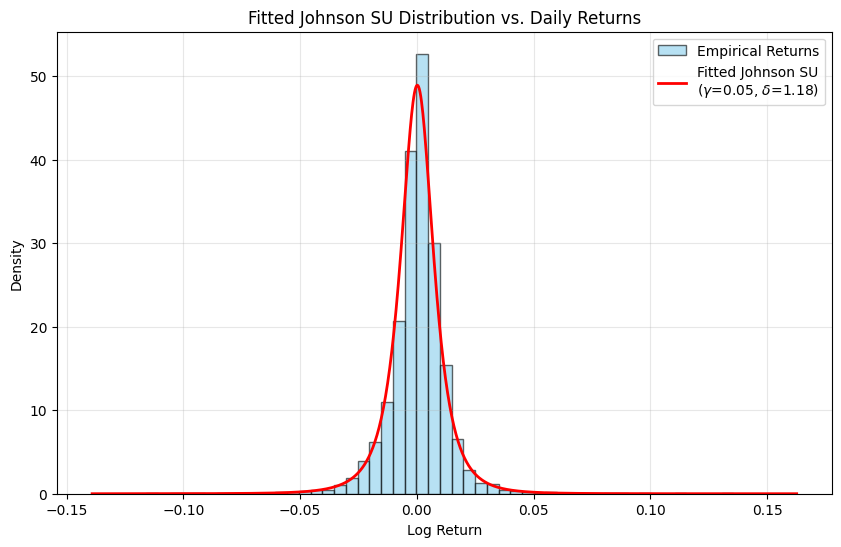

In [ ]:
# Getting our SU Johnson Parameters from our sample moments, taking those params back to moments and comparing

# Gamma, Delta, Xi, Lam are "SU Johnsons Moments", they describe a distribution like the moments used in the parameter of this function
gamma, delta, xi, lam = fit_johnson_su_moments(returns_mean, returns_variance, returns_skewness, returns_kurtosis) # Different from Mean, Var, Skew.... Specific to SU Johnson

print(f"Fitted Params: Gamma={gamma:.2f}, Delta={delta:.2f}, Xi={xi:.5f}, Lam={lam:.5f}") # Printing our SU johnson parameters calculated above

sim_moments = get_johnson_su_moments(gamma, delta, xi, lam)
print("Theoretical Moments of Fit:", sim_moments)

plot_johnson_vs_actual(returns, gamma, delta, xi, lam, 50)

In [ ]:
# Generate a Treshold and use it as a buy signal
target_percentile = 0.01
thresh = get_jsu_threshold(target_percentile, gamma, delta, xi, lam) # Gets a return value from a target percentile using SU Johnson parameters
print(f"The return at the bottom {target_percentile*100}% of the distribution is: {thresh:.6f}")

dr_df['Buy'] = np.where(dr_df['Daily Return'] < thresh, 1, 0) # If the daily return is above the threshold, column = 1, else 0

buy_cost = 1.01 # We add 1% to the price we buy
sell_cost = 0.99 # We subtract 1% from the price we sell

dr_df['Strategy Return'] = np.log((dr_df['Adj Close'] * sell_cost) / (dr_df['Adj Close'].shift(1) * buy_cost)) * dr_df['Buy'].shift(1) # Log return of today - yesterday * buy signal of yesterday
# If we didn't buy yesterday we have no return, if we did, we have a return

strategy_returns_df = dr_df[dr_df['Strategy Return'] != 0].dropna() # Get rid of days where we didn't trade or our values are NaN
strategy_returns = strategy_returns_df['Strategy Return'].tolist() # Get these returns to a list

print(strategy_returns)

The return at the bottom 1.0% of the distribution is: -0.034812
[-0.004212707426002075, 0.028330363283649816, 0.010295974775603843, -0.008399827098071447, 0.0021085725723362678, -0.03607839907279169, 0.027109358911525324, 0.008171875919973553, -0.017669033283952564, 0.004198644271852228, 0.01059891837230528, 0.023239845934694428, 0.03455619402411768, -0.019592216462446358, -0.05182001815092788, -0.0315151916424412, -0.030554790031228417, 0.03481309089940184, 0.005517720187246236, -0.04214646480870733, 0.10451698137167023, -0.06300556961960266, 0.0264844316831405, 0.05447377609629574, -0.019365339542673207, -0.08313289279448736, 0.04653836116943575, 0.03176281567201601, 0.03628550575846239, -0.00012156543006792125, -0.008401308253481269, 0.03120930848147352, -0.013535391788238536, -0.0042574239034702645, 0.003222408672300396, 0.013348891398592988, 0.008493658285378004, -0.018529031218004265, -0.007497896286312232, 0.03945047881626905, 0.03790564885098795, -0.022465281015613087, 0.003374

In [55]:
t_stat, p_val = stats.ttest_1samp(strategy_returns, returns_mean)
t_stat

np.float64(0.10175480034754983)